In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from time import time
import os
import sys
from os.path import join, abspath
parent_dir = os.path.dirname(os.getcwd())
root_dir =abspath(join(parent_dir, ".."))
sys.path.append(root_dir)
from mcmc import no
from mcmc import utils
from tqdm import tqdm

In [ ]:
# plt.style.available

In [3]:
utils.style("seaborn-v0_8-deep")

# tes potential

In [4]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-3]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw = [2]
log_a = [.5]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw + log_a]).flatten()
theta.shape

(30,)

In [5]:
z_start = -1000
z_end = 1000
dz = 1.

z = np.arange(z_start, z_end, dz)
print(z)
phi = no.potential(z, theta)

[-1000.  -999.  -998. ...   997.   998.   999.]


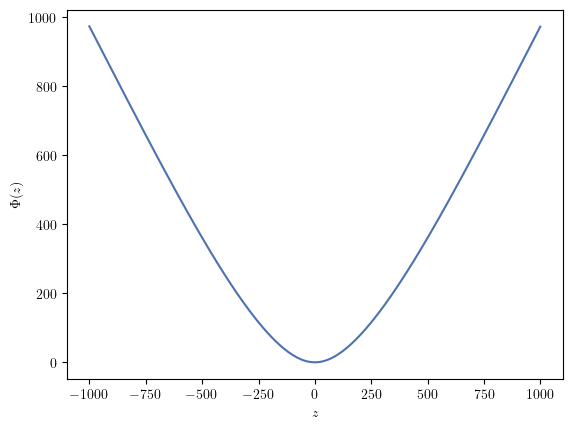

In [6]:
plt.plot(z, phi)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Phi(z)$')
plt.show()

# tes fz

In [7]:
fz = no.fz(z, theta)
fz

array([8.96121191e-10, 9.17219790e-10, 9.38815142e-10, ...,
       9.60918942e-10, 9.38815142e-10, 9.17219790e-10])

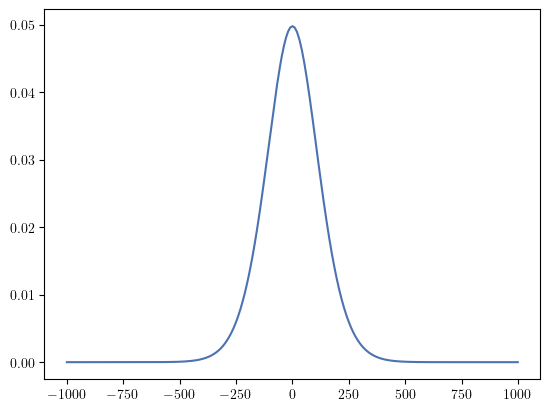

In [8]:
plt.plot(z, fz)

# tes fw

In [9]:
w = np.linspace(-50, 30, 1000)

fw = no.fw(w, theta)
fw.shape

(1000,)

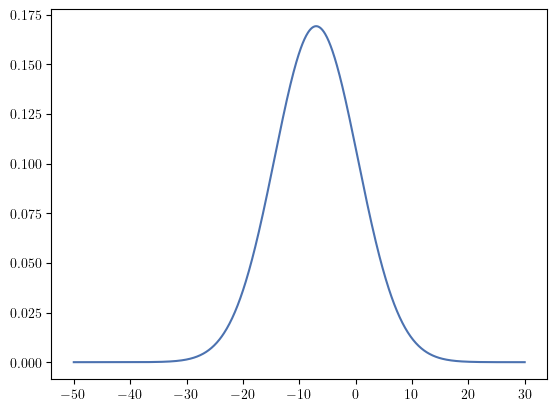

In [10]:
plt.plot(w, fw)

# tes log_prob

In [24]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-1]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw = [2]
log_a = [0]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw + log_a]).flatten()
theta.shape

(30,)

In [6]:
zdata = np.loadtxt(join(parent_dir, 'data', 'z1.csv'), skiprows=1, delimiter=',')
zmid = zdata[:, 0]
znum = zdata[:, 1]
zerr = zdata[:, 2]

wdata = np.loadtxt(join(parent_dir, 'data', 'w1.csv'), skiprows=1, delimiter=',')
wmid = wdata[:, 0]
wnum = wdata[:, 1]
werr = wdata[:, 2]

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [7]:
from scipy.optimize import curve_fit

In [8]:
def gauss(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

def kind1():
    poptz, _ = curve_fit(gauss, zmid, znum, p0=[0, 100, 1])
    poptw, _ = curve_fit(gauss, wmid, wnum, p0=[0, 10, 1])

    log_nu0 = np.log(poptz[2]/(np.sqrt(2*np.pi)*poptz[1]))
    log_sigmaw1 = np.log(poptw[1])
    log_a1 = np.log(poptw[2])

    locs = dict(
        log_nu0=log_nu0-1,
        R=3.4E-3,
        zsun=-50,
        w0=-10,
        log_sigmaw1=log_sigmaw1-1,
        log_a1=log_a1-1,
    )

    scales = dict(
        log_nu0=2,
        R=0.6E-3,
        zsun=100,
        w0=5,
        log_sigmaw1=2,
        log_a1=2,
    )
    return locs, scales

def dgauss(x, mu, sigma1, A1, sigma2, A2):
    return A1 * norm.pdf(x, mu, sigma1) + A2 * norm.pdf(x, mu, sigma2)
def kind2():
    while True:
        p0 = np.array([0])
        sigma = np.random.uniform(1, 20, size=2)
        a = np.min(sigma)/sigma
        p0 = np.append(p0, sigma)
        p0 = np.append(p0, a)
        try:
            poptz, _ = curve_fit(gauss, zmid, znum, p0=[0, 100, 1])
            poptw, _ = curve_fit(dgauss, wmid, wnum, p0=p0)
            log_nu0 = np.log(poptz[2]/(np.sqrt(2*np.pi)*poptz[1]))
            log_sigmaw1 = np.log(poptw[1])
            log_a1 = np.log(poptw[2])
            log_sigmaw2 = np.log(poptw[3])
            log_a2 = np.log(poptw[4])
            if np.isnan(log_a1) or np.isnan(log_a2):
                continue
            locs = dict(
                log_nu0=log_nu0-1,
                R=3.4E-3,
                zsun=-50,
                w0=-10,
                log_sigmaw1=log_sigmaw1-1,
                log_a1=log_a1-1.5,
                log_sigmaw2=log_sigmaw2-1,
                log_a2=log_a2-1.5,
            )

            scales = dict(
                log_nu0=2,
                R=0.6E-3,
                zsun=100,
                w0=5,
                log_sigmaw1=2,
                log_a1=3,
                log_sigmaw2=2,
                log_a2=3,
            )
            
            return locs, scales
        except RuntimeError:
            print("RuntimeError, try again...")
            continue

In [25]:
locs, scales = kind1()
keys = list(locs.keys())
locs = np.array(list(locs.values()))
scales = np.array(list(scales.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('log_nu0', -2.945700813292735, -1.0, -0.9457008132927349),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -50.0, 0.0, 50.0),
 ('w0', -10.0, -7.0, -5.0),
 ('log_sigmaw1', 0.611796183892596, 2.0, 2.6117961838925963),
 ('log_a1', -0.4121208913216201, 0.0, 1.58787910867838)]

In [26]:
no.log_prob(np.array([theta]), zdata, wdata, locs, scales)

(array([59.69784209]), array([-14427.91063443]))

# mcmc

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from time import time
import os
import sys
from os.path import join, abspath
parent_dir = os.path.dirname(os.getcwd())
root_dir =abspath(join(parent_dir, ".."))
sys.path.append(root_dir)
from mcmc import no
from mcmc import utils
from tqdm import tqdm
utils.style("seaborn-v0_8-deep")

/home/alisyaifudin/anaconda3/envs/maturin/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [12]:
zdata = np.loadtxt(join(parent_dir, 'data', 'z1.csv'), skiprows=1, delimiter=',')
zmid = zdata[:, 0]
znum = zdata[:, 1]
zerr = zdata[:, 2]

wdata = np.loadtxt(join(parent_dir, 'data', 'w1.csv'), skiprows=1, delimiter=',')
wmid = wdata[:, 0]
wnum = wdata[:, 1]
werr = wdata[:, 2]

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [2]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-1]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw = [2]
log_a = [0]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw + log_a]).flatten()
theta.shape

(30,)

In [3]:
ndim = 30
nwalkers = 2*ndim+2
nsteps = 10

In [9]:
locs, scales = kind1()
keys = list(locs.keys())
locs = np.array(list(locs.values()))
scales = np.array(list(scales.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('log_nu0', -2.945700813292735, -1.0, -0.9457008132927349),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -50.0, 0.0, 50.0),
 ('w0', -10.0, -7.0, -5.0),
 ('log_sigmaw1', 0.611796183892596, 2.0, 2.6117961838925963),
 ('log_a1', -0.4121208913216201, 0.0, 1.58787910867838)]

In [13]:
p0 = no.generate_p0(nwalkers, locs, scales, kind=1)
p0.shape

(62, 30)

In [14]:
no.log_prob(p0, zdata, wdata, locs, scales)

(array([43.22035738, 50.29998196, 45.63770558, 50.33667271, 48.33426731,
        48.24977366, 48.06363791, 46.18853806, 50.22063596, 49.09606215,
        48.44298921, 48.29308358, 51.3290438 , 48.59403152, 50.40938443,
        50.63017043, 46.35474125, 48.60766768, 44.49341093, 49.21450084,
        45.6495018 , 43.88388583, 51.84234247, 46.77913226, 47.50694184,
        46.30746523, 44.58370699, 47.44594258, 53.2302499 , 47.9219965 ,
        47.16057516, 50.97158602, 45.79936904, 43.15928238, 51.6230279 ,
        44.23124155, 51.65130367, 51.24108443, 47.81283151, 53.23477928,
        50.59284338, 53.59495019, 49.18674619, 46.99300983, 47.07369946,
        43.41742867, 45.55797622, 49.46907396, 38.95374993, 47.85454981,
        52.04479141, 45.76147147, 47.63302565, 47.19622877, 46.86081158,
        50.02214534, 37.75318371, 48.29778444, 49.80264984, 51.20644148,
        42.25608725, 47.05923156]),
 array([ -3853.19729271,  -3465.19073775,  -3702.60649913, -35165.07672776,
         -39

(30,)


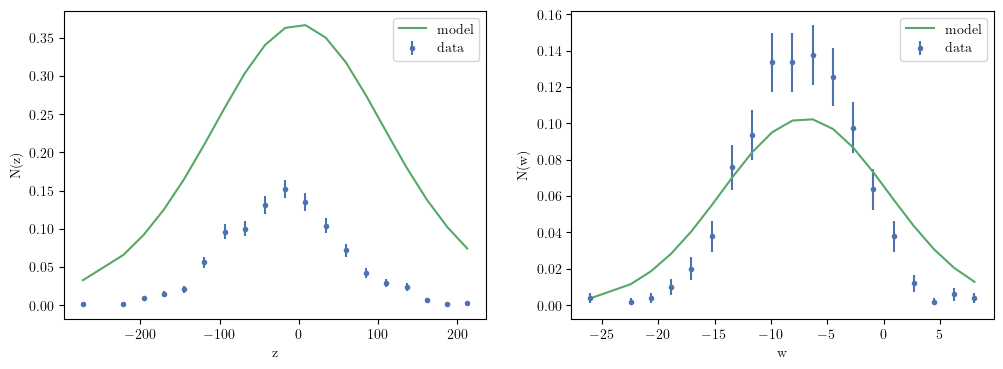

(array([59.69784209]), array([-14427.91063443]))

In [16]:
print(theta.shape)
zmod = no.fz(zmid, theta)
wmod = no.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
no.log_prob(np.array([theta]), zdata, wdata, locs, scales)

In [19]:
t0 = time()
sampler = no.run_mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True)
print(time() - t0, "s")
chain, probs = sampler[:,:,:-3], sampler[:,:,-3:]

Acceptance rate: 0.26806451612903226
24.84954595565796 s


 62%|██████▍   | 311/500 [00:15<00:09, 19.96it/s]

In [ ]:
# t0 = time()
# sampler = dm.run_mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True, batch=5)
# print(time() - t0, "s")
# chain, probs = sampler[:,:,:-3], sampler[:,:,-3:]

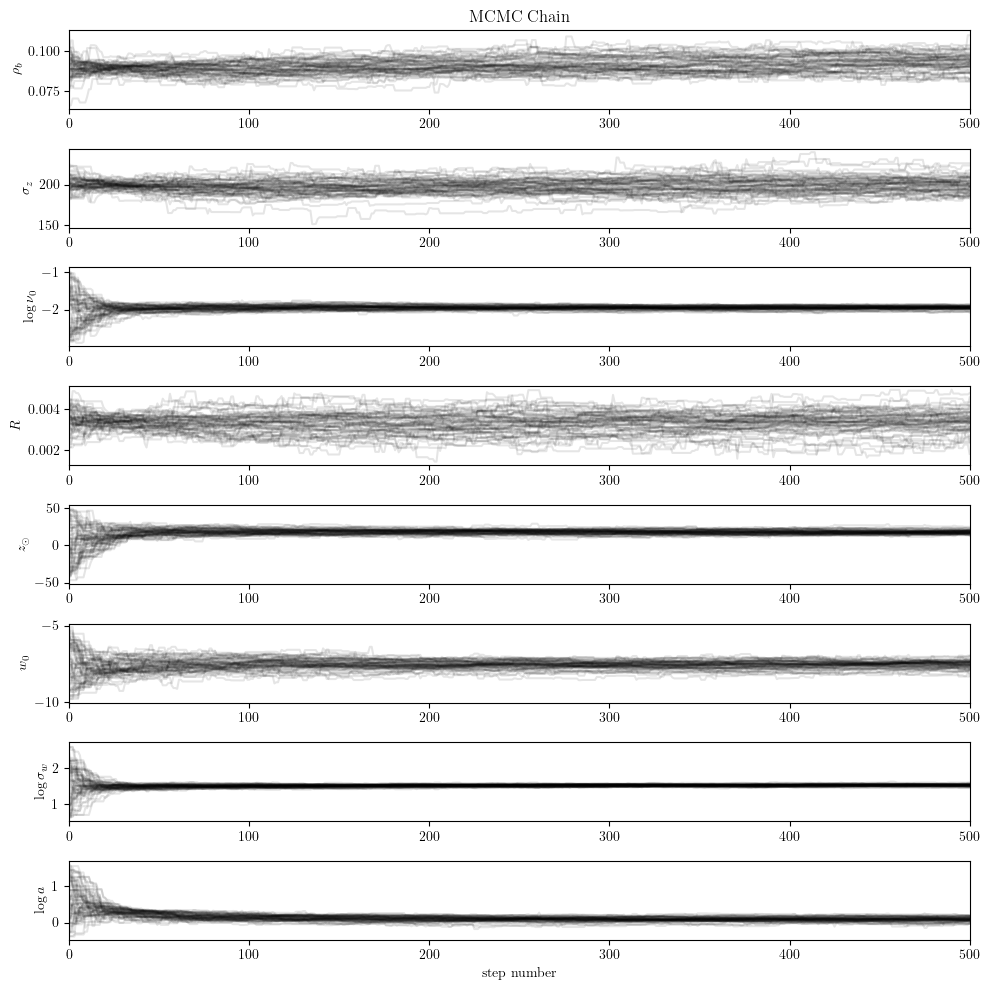

In [20]:
rhob = chain[:, :, :12].sum(axis=2).T
sigmaz = chain[:, :, 12:24].sum(axis=2).T
nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw = chain[:, :, 28].T
log_a = chain[:, :, 29].T

params = np.array([rhob, sigmaz, nu0, R, zsun, w0, log_sigmaw, log_a]).T

labels = labels = [r'$\rho_b$', r'$\sigma_z$', r'$\log \nu_0$', r'$R$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_w$', r'$\log a$']
utils.plot_chain(params, labels)

In [21]:
p0_next = chain[-1, :, :]
t0 = time()
sampler = no.run_mcmc(1000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True)
print(time() - t0, "s")
chain, probs = sampler[:,:,:-3], sampler[:,:,-3:]

Acceptance rate: 0.24938709677419355
49.46273970603943 s


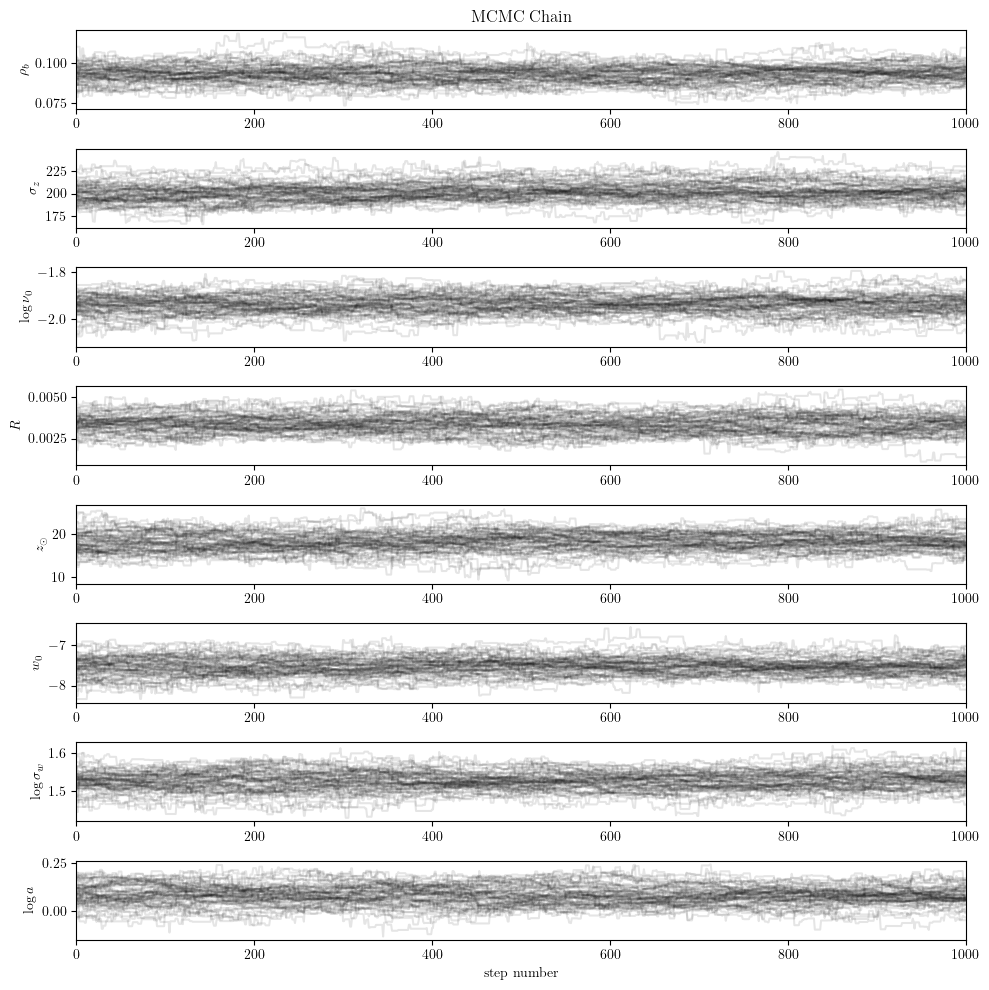

In [22]:
rhob = chain[:, :, :12].sum(axis=2).T
sigmaz = chain[:, :, 12:24].sum(axis=2).T
nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw = chain[:, :, 28].T
log_a = chain[:, :, 29].T

params = np.array([rhob, sigmaz, nu0, R, zsun, w0, log_sigmaw, log_a]).T

labels = labels = [r'$\rho_b$', r'$\sigma_z$', r'$\log \nu_0$', r'$R$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_w$', r'$\log a$']
utils.plot_chain(params, labels)

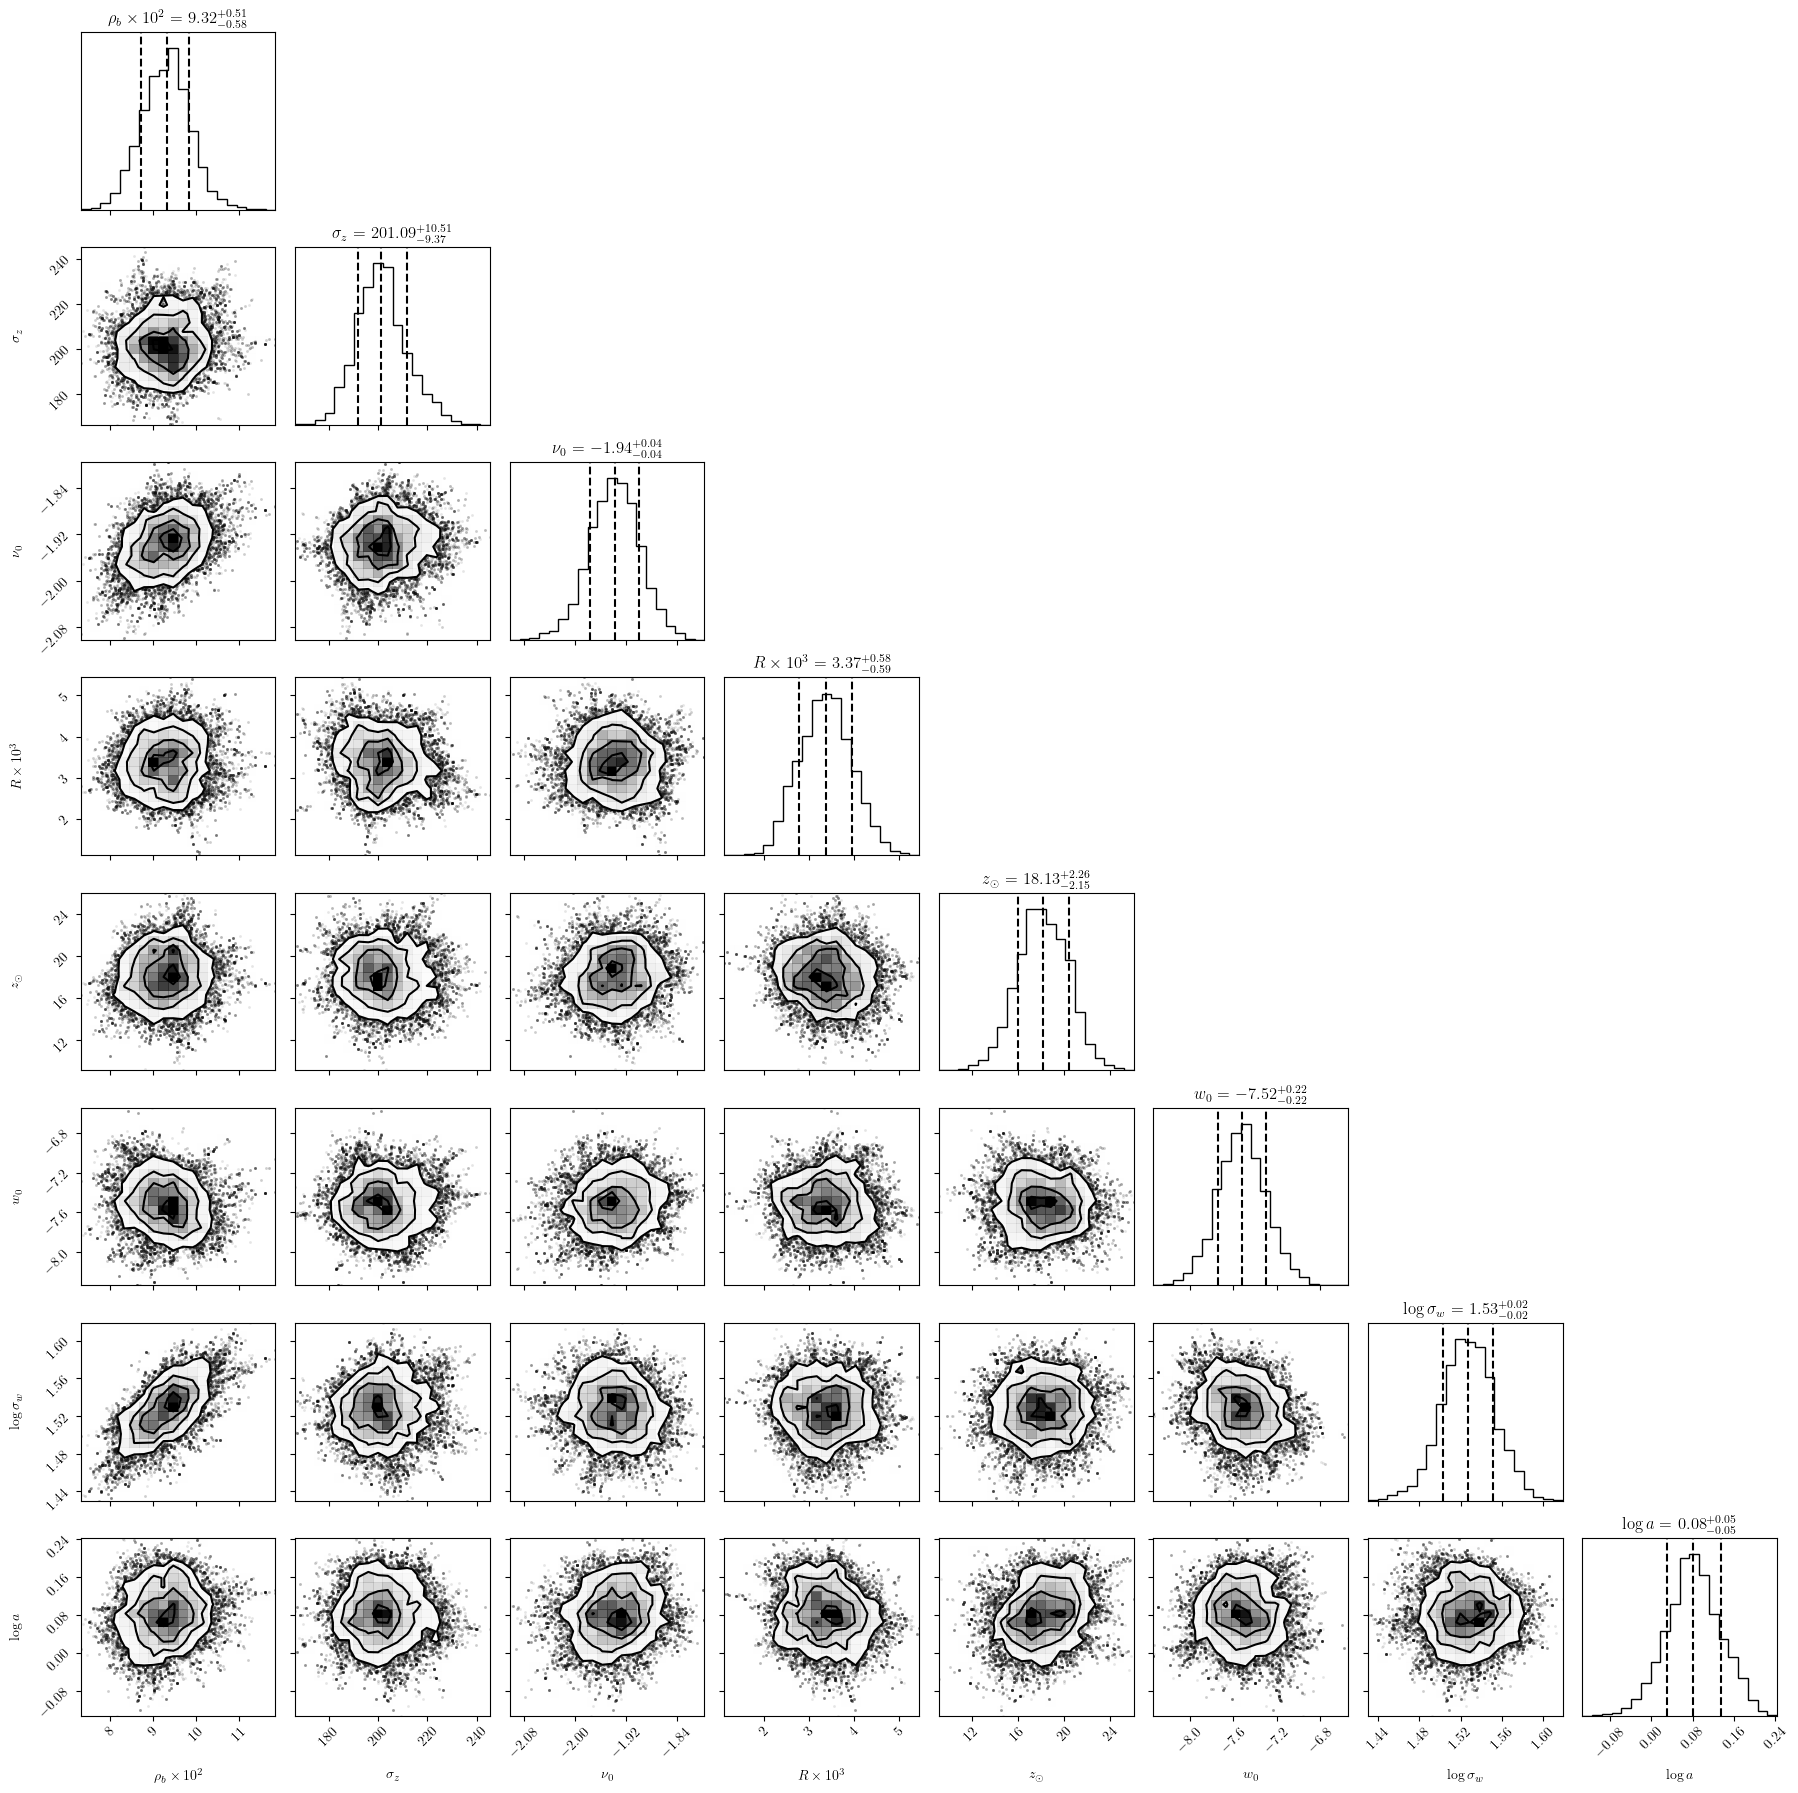

In [23]:
rhob = chain[:, :, :12].sum(axis=2).T/1E-2
sigmaz = chain[:, :, 12:24].sum(axis=2).T
nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T/1E-3
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw = chain[:, :, 28].T
log_a = chain[:, :, 29].T

params = np.array([rhob, sigmaz, nu0, R, zsun, w0, log_sigmaw, log_a]).T

labels = [r'$\rho_b\times 10^2$', r'$\sigma_z$', r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_w$', r'$\log a$']
utils.plot_corner(params, labels)

# fit

100%|██████████| 50000/50000 [00:24<00:00, 2005.14it/s]


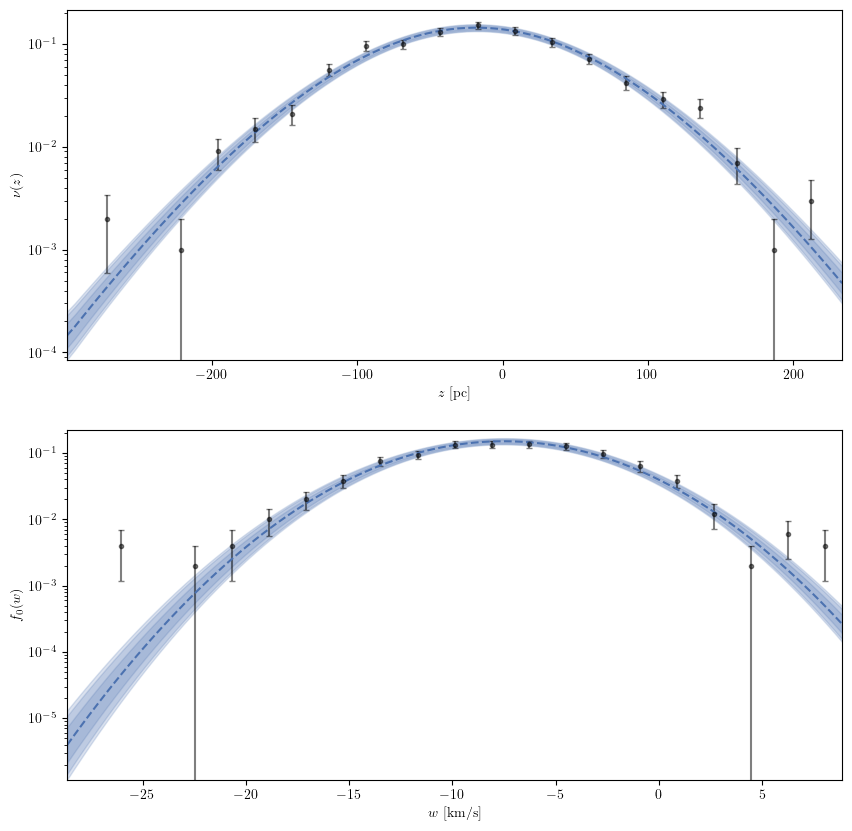

In [25]:
utils.plot_fit(no, zdata, wdata, chain, ndim)